## Import the required libraries

In [1]:
import os
import zipfile
import os, warnings
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as img
from matplotlib import gridspec

import random
import numpy as np
import tensorflow as tf

#from random import randint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.utils import image_dataset_from_directory, load_img, img_to_array
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, InputLayer, Resizing, Convolution2D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.applications.inception_v3 import preprocess_input, InceptionV3

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Unsip the files

In [2]:
import zipfile

zip_files = ['test', 'train']

for zip_file in zip_files:
    with zipfile.ZipFile("../input/dogs-vs-cats-redux-kernels-edition/{}.zip".format(zip_file),"r") as z:
        z.extractall(".")
        print("{} unzipped".format(zip_file))

test unzipped
train unzipped


In [3]:
Train_Folder_Path = "../working/train"
Test_Folder_Path = "../working/test"
train_file_names = os.listdir(Train_Folder_Path)
test_file_names = os.listdir(Test_Folder_Path)


In [4]:
targets = []
full_paths = []
for file_name in train_file_names:
    target = file_name.split(".")[0]
    full_path = os.path.join(Train_Folder_Path, file_name)
    full_paths.append(full_path)
    targets.append(target)
train_df = pd.DataFrame()
train_df['image_path'] = full_paths
train_df['target'] = targets

full_paths = []
for file_name in test_file_names:
    target = file_name.split(".")[0]
    full_path = os.path.join(Test_Folder_Path, file_name)
    full_paths.append(full_path)
test_df = pd.DataFrame()
test_df['image_path'] = full_paths

In [5]:
test_label = []
a = os.listdir("../working/test")
for i in range(len(a)):
    test_label.append(a[i].split(".")[0])
test_label[0:5]

['2827', '11753', '2096', '12331', '3270']

## Visualize the data

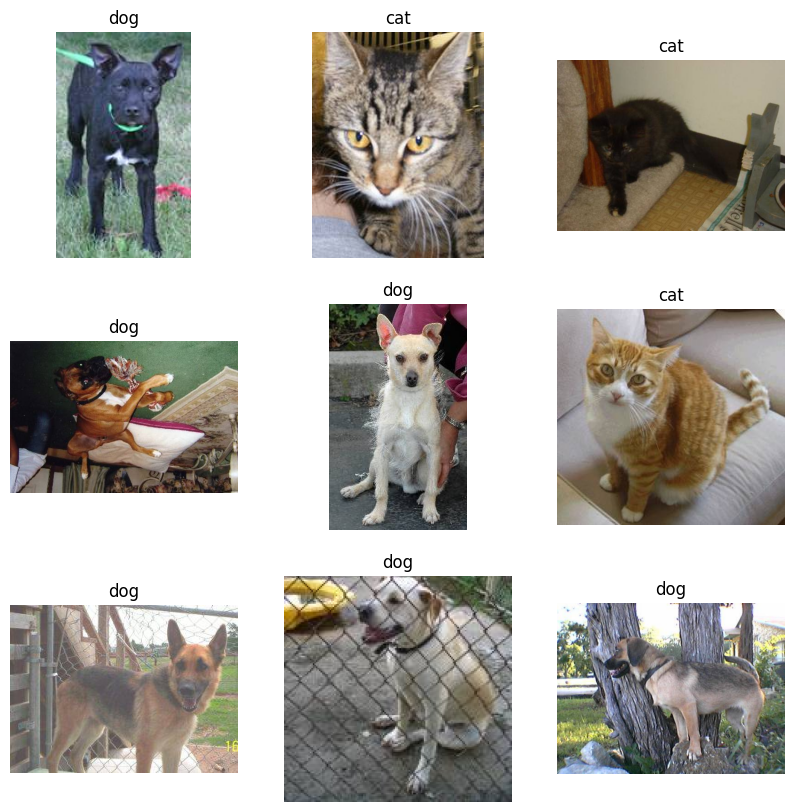

In [ ]:
class_names = ["cat", "dog"]

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    j = random.randint(0, 25000)
    plt.imshow(img.imread(train_df.iloc[j,0]))
    plt.title(train_df.iloc[j,1])
    plt.axis('off')
plt.show()


## Split the data

In [ ]:
train_data,val_data = train_test_split(train_df,random_state=234)

In [ ]:
train_data.shape

In [9]:
np.random.seed(1234)

# If you run into memory errors, try reducing this
batch_size = 32

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, zoom_range=.18,rotation_range=10,shear_range=0.1,
                            horizontal_flip=True,width_shift_range=0.1,height_shift_range=0.1)
train_data_generator = train_datagen.flow_from_dataframe(dataframe=train_data,x_col='image_path',y_col='target',
                                                  target_size=(224,224),class_mode='binary',batch_size=batch_size,shuffle=False)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_data_generator = val_datagen.flow_from_dataframe(dataframe=val_data,x_col='image_path',y_col='target',
                                                  target_size=(224,224),class_mode='binary',batch_size=batch_size,shuffle=False)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_data_generator = test_datagen.flow_from_dataframe(dataframe=test_df,x_col='image_path',y_col=None,
                                                  target_size=(224,224),class_mode=None,batch_size=batch_size,shuffle=False)                                     


## Define the model

In [10]:
iv3 = InceptionV3(weights="imagenet", include_top=False, input_shape=(224,224,3))
iv3.trainable = False

87910968/87910968 [==============================] - 3s 0us/step


In [11]:
model = Sequential([
    iv3,
    Flatten(),
    Dense(100, activation='relu'),
    Dense(1, activation='sigmoid'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 100)               5120100   
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 26,922,985
Trainable params: 5,120,201
Non-trainable params: 21,802,784
_________________________________________________________________


## Train the model

In [12]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

early_stopping = EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True
)

history = model.fit(
    train_data_generator,
    steps_per_epoch=train_data.shape[0]/batch_size,
    validation_data=val_data_generator,
    validation_steps=val_data.shape[0]/batch_size,
    epochs=200,
    callbacks=[early_stopping],verbose=1
)

Epoch 1/200
585/585 [==============================] - 245s 400ms/step - loss: 0.2163 - binary_accuracy: 0.9737 - val_loss: 0.0960 - val_binary_accuracy: 0.9803
Epoch 2/200
585/585 [==============================] - 228s 390ms/step - loss: 0.0689 - binary_accuracy: 0.9820 - val_loss: 0.0441 - val_binary_accuracy: 0.9802
Epoch 3/200
585/585 [==============================] - 232s 395ms/step - loss: 0.0368 - binary_accuracy: 0.9871 - val_loss: 0.0562 - val_binary_accuracy: 0.9846
Epoch 4/200
585/585 [==============================] - 226s 386ms/step - loss: 0.0359 - binary_accuracy: 0.9869 - val_loss: 0.0422 - val_binary_accuracy: 0.9877
Epoch 5/200
585/585 [==============================] - 228s 390ms/step - loss: 0.0347 - binary_accuracy: 0.9877 - val_loss: 0.0363 - val_binary_accuracy: 0.9882
Epoch 6/200
585/585 [==============================] - 236s 402ms/step - loss: 0.0317 - binary_accuracy: 0.9885 - val_loss: 0.0357 - val_binary_accuracy: 0.9866
Epoch 7/200
585/585 [=============

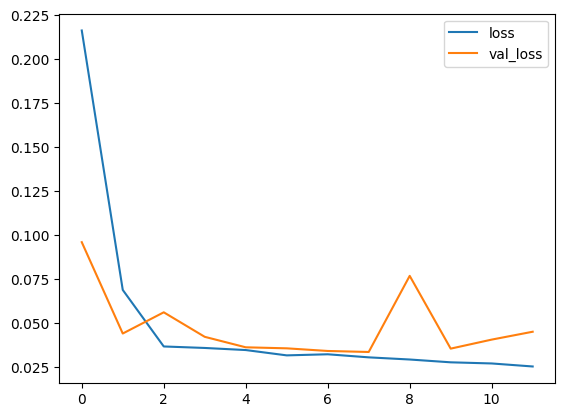

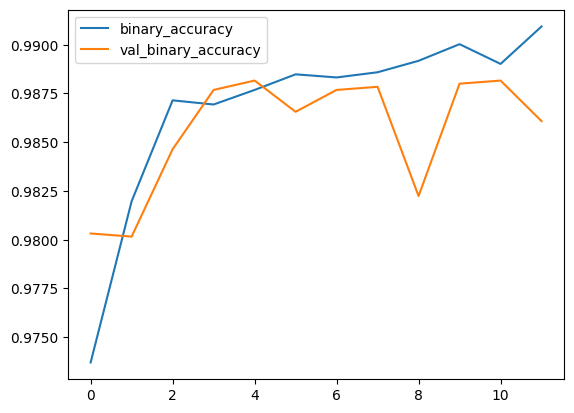

In [13]:
import pandas as pd

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

In [14]:
score=model.evaluate(val_data_generator)
print(score[1])

196/196 [==============================] - 15s 76ms/step - loss: 0.0342 - binary_accuracy: 0.9877
0.9876800179481506


## Make the predictions

In [15]:
predictions = model.predict(test_data_generator)

391/391 [==============================] - 32s 78ms/step


In [16]:
output = pd.DataFrame({'id': test_label, 'label': np.round(predictions).flatten().astype(int)})
output.to_csv('submission_data_augmented_InceptionV3_and_CNN.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
